In [1]:
#  %pip install dython
#  %pip install gensim
#  %pip install catboost

In [ ]:
from dython.nominal import associations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from gensim.models import FastText
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from PIL import Image

# Exploratory Data Analysis (EDA)

---

##  Step 1: Data Loading and Initial
Loading train and test data, initial constant variables, first view on dataset

In [3]:
PATH_TO_TRAIN_INFO = '/kaggle/input/avito-exam-dataset/train.parquet'
PATH_TO_TEST_INFO = '/kaggle/input/avito-exam-dataset/test.parquet'
PATH_TO_TEST_IMAGES = '/kaggle/input/avito-exam-dataset/test/test'
PATH_TO_TRAIN_IMAGES = '/kaggle/input/avito-exam-dataset/train/train'

In [4]:
train_info = pd.read_parquet(PATH_TO_TRAIN_INFO)
test_info = pd.read_parquet(PATH_TO_TEST_INFO)

### Lets describe the dataset columns

- **item_id** - unique id of advertisement. Almost useless for prediction targets (`['real_weight',	'real_height',	'real_length',	'real_width']`)
- **order_date** - Almost useless for prediction targets, can be dropped
- **item_condition** - This string variable can be considee like ordinal. Unique values: `['Б/у', 'Новое с биркой', 'Новое', 'Отличное', None, 'Хорошее',
       'Новый', 'Как новое', 'Удовлетворительное'] `. Some categories seems similar. Almost useless for prediction.
- **item_price** - float variable, price of item in RUB. Slightly correlates with targets
- **category_name** - Unique values : `['Транспорт', 'Личные вещи', 'Электроника', 'Для дома и дачи',
       'Хобби и отдых']`. Can be usefull for separate some cars and other large-size stuff
- **subcategory_name** - More detalized information about categories. Combinations with categories :
  
    'Для дома и дачи': `['Мебель и интерьер', 'Посуда и товары для кухни', 'Ремонт и строительство', 'Бытовая техника']`,
  
    'Личные вещи': `['Одежда, обувь, аксессуары', 'Товары для детей и игрушки', 'Детская одежда и обувь', 'Красота и здоровье', 'Часы и украшения']`,
  
    'Транспорт': `['Запчасти и аксессуары']`,
  
    'Хобби и отдых': `['Книги и журналы', 'Спорт и отдых', 'Коллекционирование', 'Охота и рыбалка', 'Велосипеды', 'Музыкальные инструменты']`,
  
    'Электроника': `['Игры, приставки и программы', 'Товары для компьютера', 'Оргтехника и расходники', 'Ноутбуки', 'Аудио и видео', 'Телефоны', 'Планшеты и электронные книги', 'Фототехника', 'Настольные компьютеры']`

- **microcat_name**  - More-more detalized information about the category. One of the most important feature. There are a lot of unique combinations with subcategories_name
- **seller id** and **buyer_id** - some unique identifications. must be dropped
- **title** - Actually short description about item. A lot of unique string values
- **description** - Detalized info about the item.
- **image_name**,	**real_weight**,	**real_height**,	**real_length**,	**real_width** - targets
  

In [5]:
# Remove unique IDs and order date as they obviously do not affect product dimensionsв
# Keep item_price for now. For example, a low price might suggest a small item
# This might be useful information when combined with other features, but it needs verification
# (Note: keeping item_price in the feature list)
# Remove description because targets can almost always be determined from the title and image

columns_to_drop = ['item_id', 'order_date', 'seller_id', 'buyer_id', 'item_condition', 'description']
train_info = train_info.drop(columns = columns_to_drop)

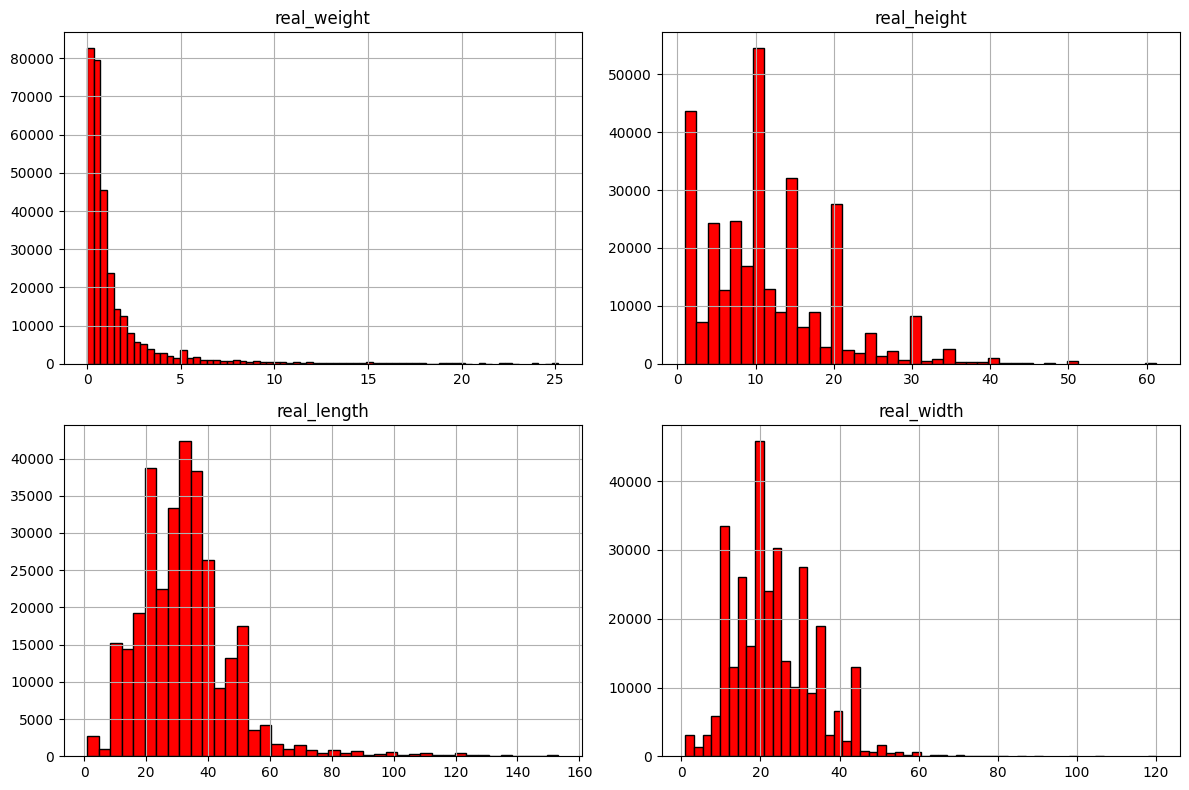

In [6]:
targets = ['real_weight',	'real_height',	'real_length',	'real_width']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Empirically chosen values for plotting graphs
min_objects = [50, 30, 30, 30]
bins = [20000, 200, 30000, 5000]

for i, target in enumerate(targets):
    counts, edges = np.histogram(train_info[target], bins=bins[i])

    # Only plot categories with more than min_objects[i] items
    mask = counts >= min_objects[i]
    filtered_counts = counts[mask]
    bin_centers = (edges[:-1][mask] + edges[1:][mask]) / 2
    
    axes[i].bar(bin_centers, filtered_counts, width=edges[1]-edges[0], color = 'red', edgecolor= 'black')
    axes[i].set_title(target)
    axes[i].grid(True)

plt.tight_layout()

### Notes

- **real_wight** distribution similar to log-normal. We can see that there are a lot of flot items
-  Distribution shows tails despite many bins; most items have small **real_height**
- **real_length** and **real_width** distributions appear normal, possibly with similar medians  
- **real_length** and **real_height** have wider value ranges

In [7]:
# Predict ln(1 + real_weight) instead of the raw real_weight
# Do the same for other targets to align the loss and the metric
for target in targets:
    train_info[target] = np.log1p(train_info[target])

train_info.columns = ['item_price', 'category_name', 'subcategory_name', 'microcat_name','title',
                      'image_name', 'log_weight','log_height', 'log_length', 'log_width']
log_targets = ['log_weight','log_height', 'log_length', 'log_width']

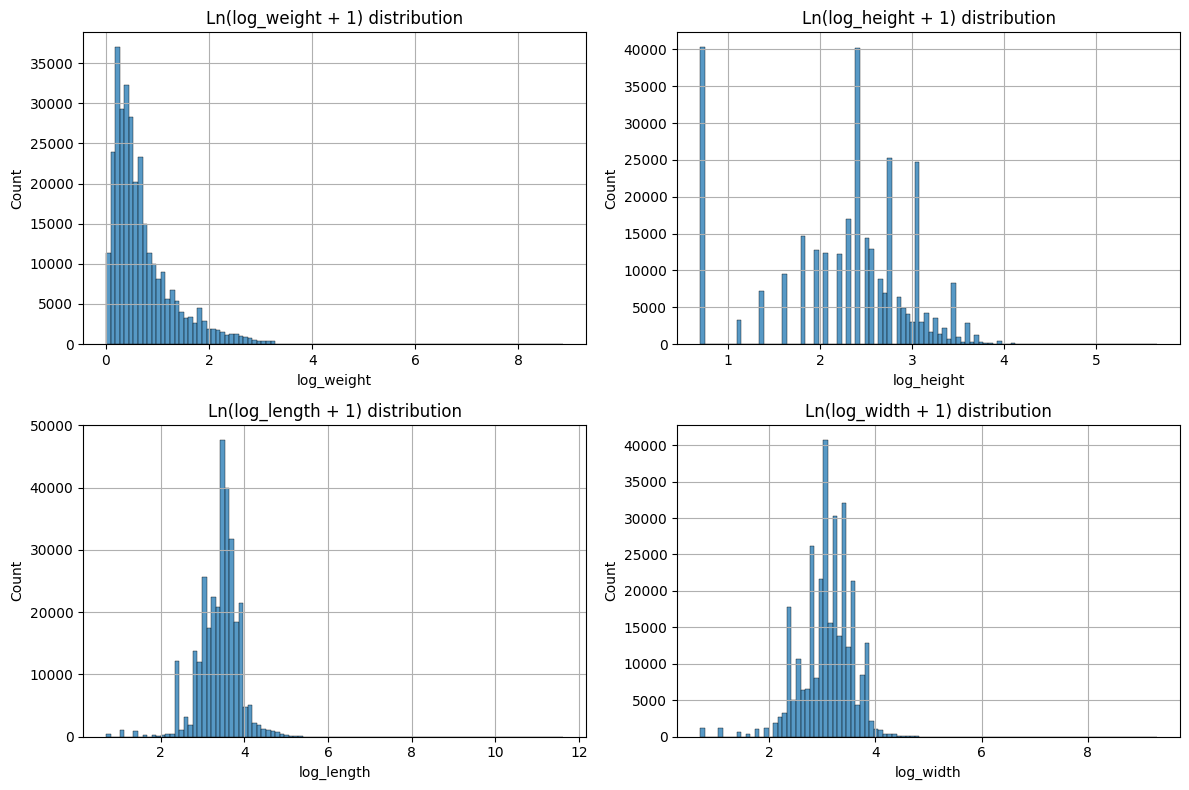

In [8]:
# Plot all items with log-transformed targets
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, target in enumerate(log_targets):
    sns.histplot(train_info[target], bins=100, ax=axes[i])
    axes[i].set_title(f'Ln({target} + 1) distribution')
    axes[i].grid(True)

plt.tight_layout()

Distribution become much more compact

## Step 2: Correlation Analisys

Check hypothesis about importance of item_price, check correlation maps with other features

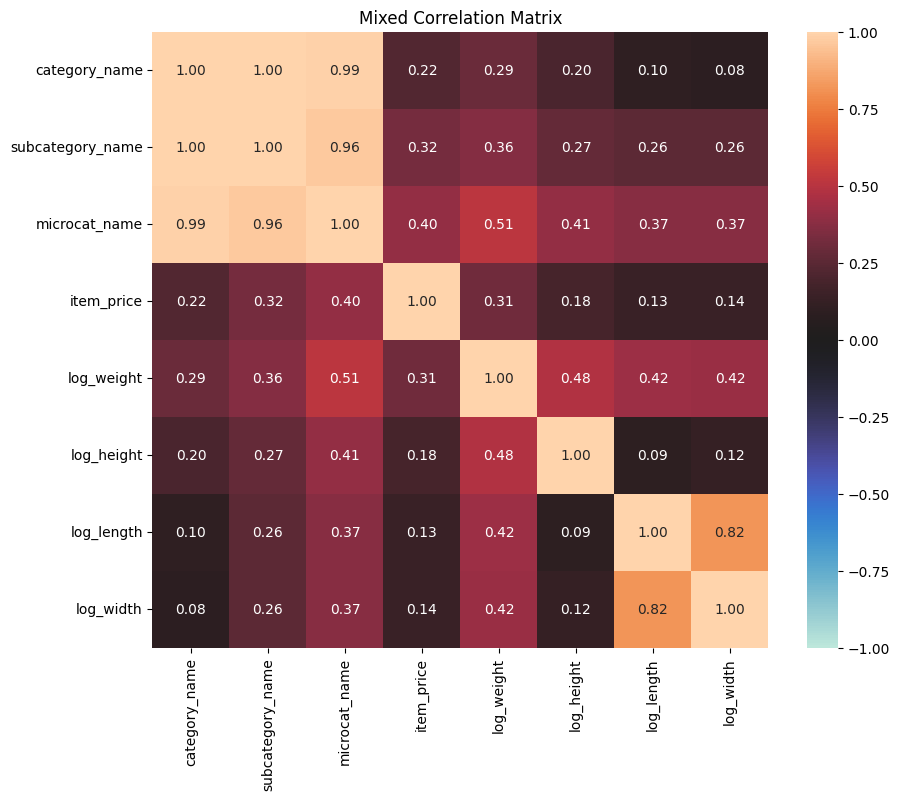

In [9]:
corr_matrix = associations(train_info[['category_name', 'subcategory_name',	'microcat_name', 'item_price'] + log_targets], 
                          nominal_columns='auto',
                          figsize=(10, 8),
                          annot=True,
                          title='Mixed Correlation Matrix')

plt.show()

### Notes

- We see that **category_name**, **subcategory_name**, and **microcat_name** are almost perfectly correlated with each other. 
Therefore, it might be beneficial to keep only the **microcat_name** because it generally contains the most essential information about the targets.
- **item_price** has some correlation with **real_weight** - it is the reason to keep it

In [10]:
new_drops = ['category_name', 'subcategory_name']
columns_to_drop.extend(new_drops)

train_info = train_info.drop(columns = new_drops)

## Step 3: Check images

Check size of images, format. Padding

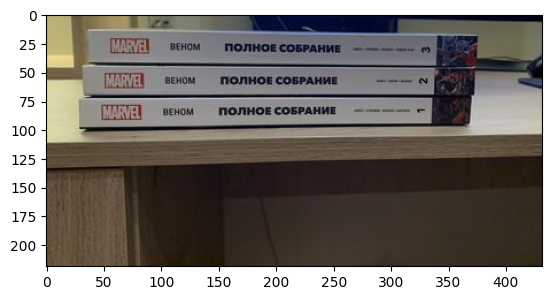

In [11]:
# Take a look at some images
index = 6969
im = plt.imread(os.path.join(PATH_TO_TRAIN_IMAGES, train_info.image_name.iloc[index]))
plt.imshow(im);

In [12]:
# Check the resolution distribution for a subset of images
height_list, width_list = [], []

for img_name in train_info.image_name[:5_000]:
    numpy_image = plt.imread(os.path.join(PATH_TO_TRAIN_IMAGES, img_name))
    height, width, _ = numpy_image.shape
    height_list.append(height)
    width_list.append(width)

print(f'Min, Max, Average height = {min(height_list)}, {max(height_list)}, {np.mean(height_list):.2f}')
print(f'Min, Max, Average width = {min(width_list)}, {max(width_list)}, {np.mean(width_list):.2f}')

Min, Max, Average height = 82, 324, 319.21
Min, Max, Average width = 104, 432, 291.96


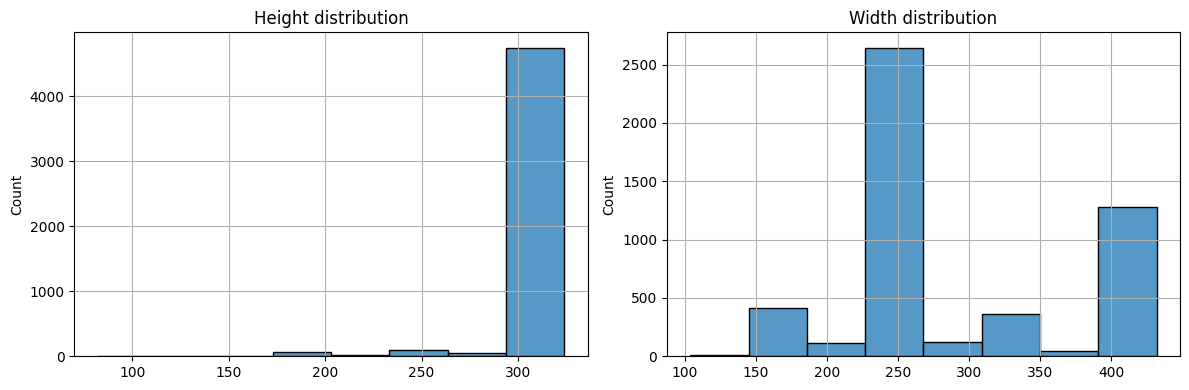

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

for i, value in enumerate([height_list, width_list]):
    sns.histplot(value, bins=8, ax=axes[i])
    axes[i].set_title(f'{["Height", "Width"][i]} distribution')
    axes[i].grid(True)

plt.tight_layout()

### Notes

- Most images share the same few sizes, such as ~320px height and ~240px width
- Specific clusters: the width has a few concentration points where most width of images is grouped, mainly around 240px and 430px

# Train model

---

## Create Baseline Model

On this step we will try to make model using only **mircocat_name** and **title**

Base approach:

- Poor CatBoost with built-in methods processing categorical and text features and built-in multi-regression
  

In [14]:
train_info_baseline = train_info[['microcat_name', 'title'] + log_targets]

In [15]:
train_info_baseline

,microcat_name,title,log_weight,log_height,log_length,log_width
0,Салон,Ручка АКПП mercedes w203 avangarde,0.314811,2.397895,3.178054,2.995732
1,Зимние куртки и пуховики,Пуховик Moncler голубой (52 размер),1.248755,2.708050,3.637586,3.218876
2,Двигатель,Запчасти на ford фокус1,0.494696,2.079442,3.178054,2.944439
3,Игровые приставки и аксессуары,Ps3 cechc 08 скальпирована HEN(полностью испра...,2.091864,3.044522,3.583519,3.044522
4,"Джемперы, свитеры, кардиганы",Свитер трикотаж 44 р-р Reserved,0.336472,2.079442,3.178054,2.484907
...,...,...,...,...,...,...
312903,Приборы и аксессуары,Массажер электрический Relax&Tone,0.693147,2.708050,3.295837,3.295837
312904,Медицинские изделия,Матрас противопролежневый трубчатый armed,1.939605,3.091042,3.806662,3.555348
312905,Защита и декор,Спойлер /KIA023/ Kia Optima (2010-13),1.187843,2.484907,4.812184,3.433987
312906,Туфли,Туфли Carnaby 40 размер,0.565314,2.484907,3.401197,2.708050


In [172]:
X = train_info_baseline.drop(columns=log_targets)
y = train_info_baseline[log_targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [229]:
model = CatBoostRegressor(
    task_type = 'GPU',
    loss_function='MultiRMSE',
    eval_metric='MultiRMSE',
    iterations=8000,
    learning_rate=0.03,
    depth=7,
    text_features=['title'],
    cat_features=['microcat_name']
)

In [230]:
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=2000
)

0:	learn: 1.1955749	test: 1.1914590	best: 1.1914590 (0)	total: 24ms	remaining: 3m 12s
2000:	learn: 1.0661725	test: 1.0674712	best: 1.0674712 (2000)	total: 33.9s	remaining: 1m 41s
4000:	learn: 1.0525059	test: 1.0585752	best: 1.0585752 (4000)	total: 1m 8s	remaining: 1m 8s
6000:	learn: 1.0440105	test: 1.0544046	best: 1.0544046 (6000)	total: 1m 43s	remaining: 34.4s
7999:	learn: 1.0371690	test: 1.0517381	best: 1.0517381 (7999)	total: 2m 17s	remaining: 0us
bestTest = 1.051738074
bestIteration = 7999


In [231]:
def print_metrics(model, X_test : pd.DataFrame) -> float:
    log_mae_list = []
        
    preditions = model.predict(X_test)
    
    for i, target_name in enumerate(targets):
        log_mae = mean_absolute_error(y_test.iloc[:, i], preditions[:, i]) # Since targets are log-transformed, MAE effectively becomes Log-MAE
        log_mae_list.append(log_mae)
        print(f"{target_name}: LogMAE = {log_mae}")
    
    final_score = sum(log_mae_list) / 4
    print(f"Score: {final_score}")

    return final_score

In [232]:
_ = print_metrics(model, X_test)

real_weight: LogMAE = 0.3179099881508083
real_height: LogMAE = 0.5397064728604937
real_length: LogMAE = 0.31190739898037007
real_width: LogMAE = 0.3180899417505377
Score: 0.3719034504355524


0.3719034504355524

### Note

- The LogMAE for the height target is significantly higher than the others, so it makes sense to predict it with a separate model

In [ ]:
# Submit the baseline after applying the inverse transformation to predictions using np.expm1
test_data = test_info[['microcat_name', 'title']]
log_predictions = model.predict(test_data)

real_predictions = np.expm1(log_predictions)

In [ ]:
result = pd.DataFrame(np.hstack([test_info['item_id'].values.reshape(-1, 1), real_predictions]), columns = ['item_id', 'weight', 'height', 'length', 'width'])
result.to_csv('submission_baseline.csv', index = False)

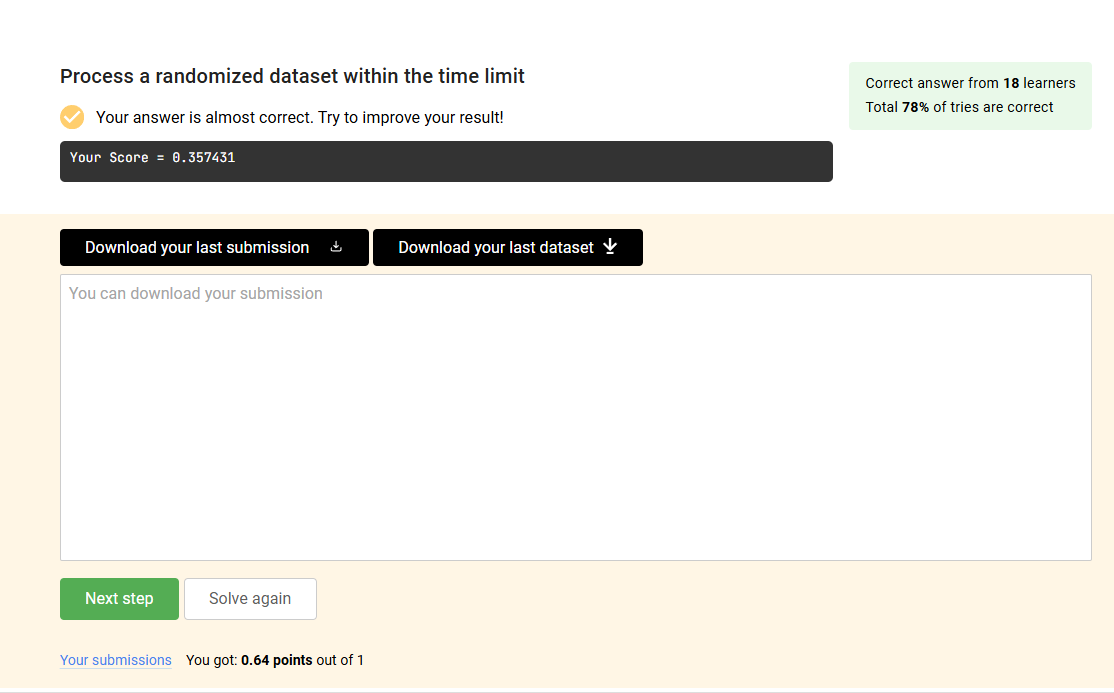

## Improve final score

The baseline model has already yielded reasonably good results. As part of our experimentation, we will try the following:

1. Try to dont use images, as it seems that the **title** and **microcat_name** should be enough. In this case, we will experiment with different feature encodings and preprocessing techniques, as well as hyperparameter tuning.

2. If the results are not satisfactory, we will train a neural network using the images associated with the items. We will also try different feature preprocessing approaches.



### Step 1: Fasttext + PCA for titles + CatBoost



In [25]:
def preprocess_text(text: str) -> list[str]:
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text) # Delete punctuation
    return text.split()

In [27]:
def get_title_vector(sentence, model):
    words = preprocess_text(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if not word_vectors:
        return np.zeros(model.vector_size)
        
    return np.mean(word_vectors, axis=0) # Mean all vectors in the title

In [47]:
def preprocess_dataset(dataset: pd.DataFrame, fasttext_model, pca_model):
    """
    Converts text titles into PCA-reduced embeddings and combines them 
    with categorical features for the model.
    """
    title_embeddings = np.array([get_title_vector(t, fasttext_model) for t in dataset['title']])
    pca_embeddings = pca_model.transform(title_embeddings)
    emb_columns = [f'pca_emb_{i}' for i in range(pca_embeddings.shape[1])]
    df_emb = pd.DataFrame(pca_embeddings, columns=emb_columns, index=dataset.index)
    result = pd.concat([dataset['microcat_name'], df_emb], axis=1)
    
    return result

In [155]:
def train_model(X : pd.DataFrame, y : pd.DataFrame, model_params : dict, 
                fasttext_model_params : dict = None, pca_n_components: int = None, 
                preprocess_func = None, use_those_ft_pca : list = None):
    """
    Trains a CatBoost model. Optionally trains FastText and PCA for text embeddings 
    or uses existing models to preprocess the input data.
    """

    # Fit fasttext and pca 
    if use_those_ft_pca is None:
        sentences = [preprocess_text(t) for t in X['title']]
        fasttext_model = FastText(sentences, **fasttext_model_params)
        
        embeddings = np.array([get_title_vector(t, fasttext_model) for t in X['title']])
        pca_model = PCA(n_components=pca_n_components)
        pca_model.fit(embeddings)
        
    # Use existed fasttext and pca models    
    else: 
        fasttext_model, pca_model = use_those_ft_pca

    if preprocess_func is not None:
        X_processed = preprocess_func(X, fasttext_model, pca_model)
    else:
        X_processed = X
        
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    model = CatBoostRegressor(**model_params)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=False,
        early_stopping_rounds=100
    )

    return model, fasttext_model, pca_model

In [ ]:
# Fix X_test to calculate metrics later 
_, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
pca_components = 10

fasttext_model_params = {
    "vector_size": 100,
    "window": 5,
    "min_count": 5,
    "sg": 1,
    "epochs": 10,
    "workers": 4
}

model_params = {
    'task_type': 'GPU',
    'loss_function': 'MultiRMSE',
    'eval_metric': 'MultiRMSE',
    'iterations': 4000,
    'learning_rate': 0.05,
    'depth': 5,
    'cat_features': ['microcat_name'],
    'verbose': False,
    'early_stopping_rounds': 100
}

We'll first use a greedy search to find the best parameters for FastText and PCA in the baseline model. After that, we'll do the same to find the best parameters for boosting among the listed options.

In [164]:
# Initial lists of params
vectors_size = [100, 150, 200, 300]
n_components = [10, 15, 20]
windows = [3, 5]

iterations = [4000, 8000]
depths = [5, 6, 7, 8]
learning_rates = [0.05, 0.03, 0.08]

In [148]:
best_log_mae_score = float('inf')
best_fasttext_model = best_pca_model = None

for vector_size in vectors_size:
    for window in windows:
        for pca_components in n_components:
            print()
            print(f'window={window}, pca={pca_components}, vec={vector_size}')

            fasttext_model_params = {
                                    "vector_size": vector_size,
                                    "window": window,
                                    "min_count": 5,
                                    "sg": 1,
                                    "epochs": 5,
                                    "workers": 4
                                    }
            
            model, fasttext_model, pca_model = train_model(
                X=X, 
                y=y, 
                model_params=model_params, 
                fasttext_model_params=fasttext_model_params, 
                pca_n_components=pca_components,
                preprocess_func=preprocess_dataset
            )

            # Score here is LogMAE
            X_test_preprocessed = preprocess_dataset(X_test, fasttext_model, pca_model)
            score = print_metrics(model, X_test_preprocessed)

            if score < best_log_mae_score:
                best_log_mae_score = score
                best_fasttext_model = fasttext_model
                best_pca_model = pca_model

            print()

        

In [149]:
best_log_mae_score 

0.36576381352084403

In [165]:
# Do the same grid search with catboost parametrs

best_log_mae_score = float('inf')
best_model = None

X_test_preprocessed = preprocess_dataset(X_test, best_fasttext_model, best_pca_model)

for iteration in iterations:
    for depth in depths:

        for learning_rate in learning_rates:
            print()
            print(f'depth={depth}, learning_rate={learning_rate}, iterations={iteration}')

            model_params = {
                            'task_type': 'GPU',
                            'loss_function': 'MultiRMSE',
                            'eval_metric': 'MultiRMSE',
                            'iterations': iteration,
                            'learning_rate': learning_rate,
                            'depth': depth,
                            'cat_features': ['microcat_name'],
                            'verbose': False,
                            'early_stopping_rounds': 100
                        }

            model, _, _ = train_model(
                X=X, 
                y=y, 
                model_params=model_params, 
                fasttext_model_params=fasttext_model_params, 
                pca_n_components=pca_components,
                preprocess_func=preprocess_dataset,
                use_those_ft_pca = [best_fasttext_model , best_pca_model]
            )

            score = print_metrics(model, X_test_preprocessed)

            if score < best_log_mae_score:
                best_log_mae_score = score
                best_model = model

            print()

In [166]:
best_log_mae_score

0.3371745958884852

In [202]:
# Submit new model after applying the inverse transformation to predictions using np.expm1
test_data = test_info[['microcat_name', 'title']]
test_data_preprocessed = preprocess_dataset(test_data, best_fasttext_model, best_pca_model)

log_predictions = best_model.predict(test_data_preprocessed)
real_predictions = np.expm1(log_predictions)

result = pd.DataFrame(np.hstack([test_info['item_id'].values.reshape(-1, 1), real_predictions]), columns = ['item_id', 'weight', 'height', 'length', 'width'])
result.to_csv('submission_catboost_ft_pca_height_sep.csv', index = False)

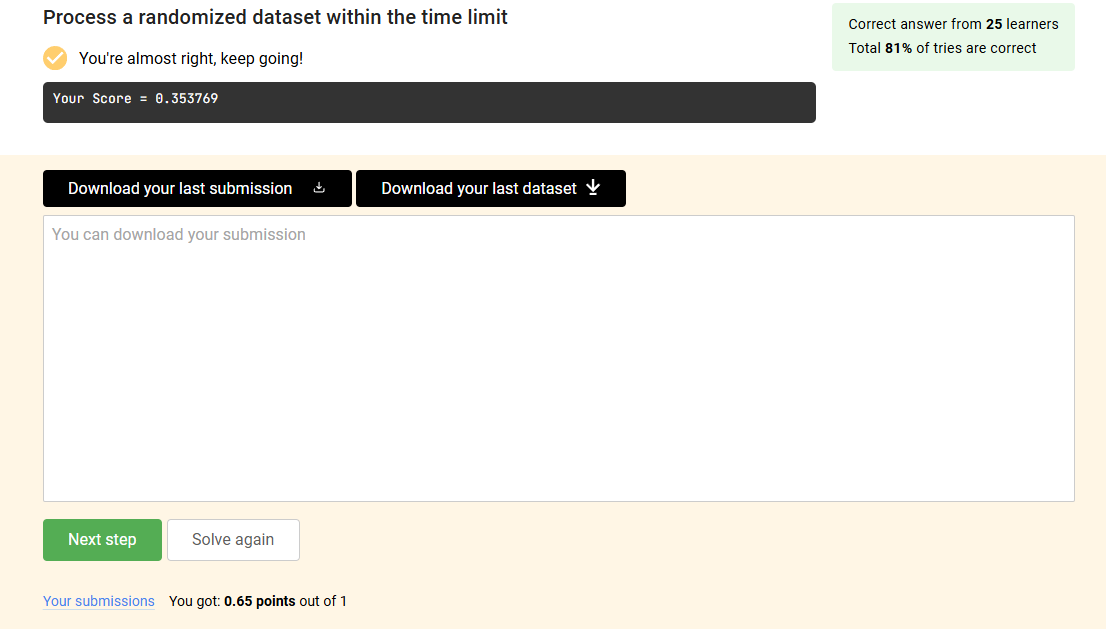

### Step 2: CLIP for images + CatBoost (or NN)

In this part of the notebook, I'm trying to add images that I previously converted into 512D embeddings using CLIP. Since that is too many dimensions for this task, they will be compressed using PCA into 32D embeddings. After obtaining them, we will perform a grid search for the boosting parameters. The text preprocessing remains the same (FastText + PCA).

In [241]:
clip = SentenceTransformer('clip-ViT-B-32')

In [259]:
def get_image_embeddings(image_names, path, batch_size=64):
    """
    Extracts visual embeddings from images using a CLIP model in batches.
    """
    all_embeddings = []

    # Use batch tecnique for optimaze RAM
    for i in range(0, len(image_names), batch_size):
        batch_names = image_names[i : i + batch_size]
        batch_images = []
        
        for name in batch_names:
            img_path = os.path.join(path, name)
            batch_images.append(Image.open(img_path))
        
        batch_embs = clip.encode(batch_images, show_progress_bar=False)
        all_embeddings.append(batch_embs)

        # Print every 1024 images to check progress
        if i % 1024 == 0:
            print(f'Processed {i} images...')

    return np.vstack(all_embeddings)

In [260]:
# Create dataframe with clip embeddings
image_names = train_info['image_name'].iloc[:].tolist()
embeddings_array = get_image_embeddings(image_names, PATH_TO_TRAIN_IMAGES)

clip_columns = [f'clip_{i}' for i in range(embeddings_array.shape[1])]
df_clip = pd.DataFrame(embeddings_array, columns=clip_columns, index=train_info.index[:])

In [2]:
# Reduce 512D embeddings to 32D using PCA
pca_clip = PCA(n_components=32, random_state=42)
clip_pca_features = pca_clip.fit_transform(df_clip)

In [276]:
df_clip['title'] = train_info['title']
df_clip['microcat_name'] = train_info['microcat_name']

# Rename for comfort
X_clip = df_clip.drop('title', axis=1)

In [269]:
# Save X_test with the same random_state as in fitting to calculate metrics later
_, X_test, _, _ = train_test_split(X_clip, y, test_size=0.2, random_state=42)

In [3]:
# Grid search for best CatBoost parameters
iterations = [8000]
depths = [6, 7, 8]
learning_rates = [0.05, 0.03, 0.08]

best_log_mae_score_clip = float('inf')
best_model_clip = None

X_test_preprocessed = preprocess_dataset(X_test, best_fasttext_model, best_pca_model)

for iteration in iterations:
    for depth in depths:
        for learning_rate in learning_rates:
            print()
            print(f'depth={depth}, learning_rate={learning_rate}, iterations={iteration}')

            model_params = {
                            'task_type': 'GPU',
                            'loss_function': 'MultiRMSE',
                            'eval_metric': 'MultiRMSE',
                            'iterations': iteration,
                            'learning_rate': learning_rate,
                            'depth': depth,
                            'cat_features': ['microcat_name'],
                            'verbose': False,
                            'early_stopping_rounds': 100
                        }

            model, _, _ = train_model(
                X=X_clip, 
                y=y, 
                model_params=model_params, 
                preprocess_func=preprocess_dataset,
                use_those_ft_pca = [best_fasttext_model , best_pca_model]
            )

            # Score here is still LogMAE
            score = print_metrics(model, X_test_preprocessed)

            if score < best_log_mae_score:
                best_log_mae_score_clip = score
                best_model_clip = model

            print()

Cell upper was stopped because score (LogMAE) was to awful to continue fitting

# Results

* **Exploratory Data Analysis (EDA)**
Conducted EDA and identified varied distributions for the targets (height, width, weight, and length).
* **Target Log Transformation**
Log-transformed all target variables to align metrics and improve optimization.
* **Baseline Model**
Trained a baseline CatBoost model using only `microcat_name` and `title` with built-in categorical and text handling, achieving a score of approximately **0.357**.
* **Metric Improvement Attempts**
Tested various preprocessing methods for `title` and `microcat_name` using **FastText** and **PCA**.
* **Hyperparameter Tuning**
Performed a grid search for boosting parameters, but found no significant improvement in the metric.
* **Image Feature Integration**
Attempted to incorporate image embeddings from **CLIP**, but this significantly degraded the model's performance.